In [3]:
import os
import import_ipynb
import pandas as pd
import itertools
import talib
import math
import numpy as np
from numpy import nan

'''to be modified and shift into property files'''
currentpath=os.getcwd()
dbpath=os.path.join(currentpath,"..",'database')
stockcsv=os.path.join(dbpath,'stockpath.csv')
stocktest=os.path.join(dbpath,'stocktest.csv')

featurescsv=os.path.join(dbpath,'features.csv')
featuresdata=os.path.join(dbpath,'featuresdata.csv')



#to import Load_Csv file from another directory. this style is for jupyter notebook
                
%cd ..
from utility import Load_Csv as lcsv
%cd stockprediction



C:\Prgs\Code\mokshtech\Fin_Product
importing Jupyter notebook from C:\Prgs\Code\mokshtech\Fin_Product\utility\Load_Csv.ipynb
C:\Prgs\Code\mokshtech\Fin_Product\stockprediction


In [4]:
class ta(lcsv.Load_csv):
    '''this class contains functions fto predict label with the help of technical indicators'''
    
    def __init__(self,filename=stockcsv):
        self.filename=filename
    

    def loadcsv(self):
        '''load 'Date','Close', 'Volume' data from databse and return dataframe
        '''
        
        self.dataset=self.LoadData(self.filename).loc[:, ['Date','Close', 'Volume','Open']]
        self.dataset['Date'] = pd.to_datetime(self.dataset['Date'])
        return self.dataset
    

    def loadfeaturesdata(self,x):
        '''load features detailed data from databse'''
        self.featuresdata=self.LoadfeaData(featuresdata)
        self.featuresdata.index=self.featuresdata[0]
        #self.featuresdata=self.featuresdata.loc[x]
        return list(self.featuresdata.loc[x,1:])
    
    
    def ti_Combinations(self):
        '''takes input as list of list and  gives output as comninations '''
        
        #print("ti_Combinations")

        self.paneldict={}
        def comb_r(row):
            
            #print(self.dataset)
            #print('row',row)
            comb_dataset=self.dataset.copy()#deep=True)  #Copy basic dataset to comb_dataset
            for i in row:
                #print('i',i)
                comb_dataset['MA'+str(i)]=self.tdf['MA'+str(i)] # add MA rows from tdf to comb_dataset as per the combination .
                #print('comb_dataset',comb_dataset)
            #print('c',comb_dataset)    #To print dataset with all combinations of MA
            
            #print('self.paneldict',self.paneldict)
            row_s=str(row)
            self.paneldict[row_s]=comb_dataset.copy()#deep=True)  # Now xfer dataframe from comb_dataset to panel_dict 
            #print('self.paneldict2',self.paneldict)


        try:
            a=self.tidict['MA']
            #print('combinations_input',a)
            #[[10],[50],[60-64]]
            comb_df=pd.Series(list(itertools.product(*a)))##get combinatons 
            #print('comb_df',comb_df)
            comb_df.apply(comb_r)
            #panel_dataset=pd.Panel(self.paneldict)
            #print('panel_dataset',panel_dataset)
         
            '''
            ### Error: Panel is not working here . 
            On printing panel it is printing merge of all unique columns for each dataframe.
            
            
            #print(item for item in panel_dataset.items])  # to print item name of panel
            #print('(2, 4, 60)',panel_dataset[(2, 4, 60)])
            
            '''
            
            
        except Exception as e:
            print('e2',e)         
       
        
    def loadfeatures(self):
        '''load feature label data from databse
        '''
        self.featurestilist=[]
        self.misc=[]
        self.label=[]
        self.tilist=dir(talib)
        self.featuredict={}
        self.tidict={}
        self.features=self.LoadfeaData(featurescsv)

         
        def func(value,args):
           

            if str(value).find("-")>-1:   #tocheck if range is given 
                a,b=value.split("-")
                a=int(a)
                b=int(b)

                self.featuredict[args].extend(list(range(a,b)))   #if range is given then replace it by list
                self.tidict[args].append(list(range(a,b))) 
               
            else:
                try:
                    var=str(args)+'-'+str(int(value))              #togenerate name like MA-1,MA-2  

                    self.featuredict[args].extend(self.loadfeaturesdata(var))
                    
                    self.tidict[args].append(self.loadfeaturesdata(var))
                except Exception as e:
                    print('e1',e)    
        
        
        def funr(row):
            r_len=len(row)
            ti=row[0]
            rowdf=pd.Series(row[1:])
            
                     
            if ti in self.tilist:
                self.featuredict[ti]=[]
                self.tidict[ti]=[]
                self.featurestilist.append(ti)
                
                rowdf.apply(func,args=(ti,))    #Vectorize function over each element
                
            elif ti=='label':
                self.label.append(row[1])
            else:
                self.misc.append(row)
    
                
                                                 #vectorize approach to speed up process        
        self.features.apply(funr, axis=1)
        #print(self.featuredict)                  #To be removed after development
        #print(self.features)
        #print("end")
        
        
        
        #return(self.featurestilist,self.label,self.misc,self.MA_comb)
        
        
        
    def get_MA(self,x):
        malist=self.featuredict['MA']
        for i in malist:
            if ('MA'+str(i)) in self.tdf:
                continue
            else:          
                self.tdf['MA'+str(i)]=talib.SMA(self.dataset[x],i)
        return(self.tdf)
        
    def get_RSI(self,x):
        rsilist=self.featuredict['RSI']
        for i in rsilist:
            if ('RSI'+str(i)) in self.tdf:
                continue
            else:
                self.dataset['RSI'+str(i)]=talib.RSI(self.dataset[x],i)
        return(self.dataset)
        
        
        
    def get_technical_indi(self):
        
        self.tdf=self.LoadData(stockcsv).loc[:, ['Close']]
        for i in self.featurestilist:
            if i=='MA':
                self.get_MA('Close')
            if i=='RSI':
                self.get_RSI('Close')
                
                
    def get_return(self):
        self.dataset['Daily_Return'] = self.dataset['Close'].pct_change()
        
        
    def get_label(self):
        print("start technical analysis and  Calculate technical indicators")
        if self.label[0]=='return':
            self.get_return()
        #print(self.dataset)
        #print(self.tdf)
        #print(self.tidict)
       
    def get_panel_data(self):
        self.loadcsv()
        self.loadfeatures()
        self.get_technical_indi()
        self.get_label()
        self.ti_Combinations()
        return self.paneldict

        
        
        

In [7]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


import matplotlib.pyplot as plt
from datetime import date
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class ml_dpmodels(object):
    def data_preprocessing(self,train_paneldict,skipdays):
    
        #print('data_preprocessing',train_paneldict)

        test_size=0.06 #b.test_size  #to split dataset in training and testing part.   

        layer=4


        df = train_paneldict.iloc[skipdays:, 1:]
        #print('df',df)
        y = train_paneldict.iloc[skipdays:, 1:2] #Close  # implement method to get label from file.
        #print(y)
        #feature scaling 
        self.sc = MinMaxScaler(feature_range = (0, 1))
        df_scaled = self.sc.fit_transform(df)
        y_scaled = self.sc.fit_transform(y)
        

        #Creating data sctructure for test and training
        #X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_scaled, test_size=test_size)
        #X_train, y_train = np.array(X_train), np.array(y_train)

        ### Split Data set as per test size. 
        
        df_scaled_shape=df_scaled.shape[0]
        splitcount=int(df_scaled.shape[0]*test_size)
        
        X_train=df_scaled[:(df_scaled_shape-splitcount),:]
        X_test=df_scaled[(df_scaled_shape-splitcount):,:]
        
        y_train=y_scaled[:(df_scaled_shape-splitcount),:]
        y_test=y_scaled[(df_scaled_shape-splitcount):,:]
        
        
        
        

        #Reshape xtrain and xtest to fit in lstm model

        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        self.X_test , self.X_train , self.y_test , self.y_train = X_test , X_train , y_test , y_train 


        return(self.X_test,self.X_train,self.y_test,self.y_train)

        
    def build_predictmodel(self,dataframe,skipdays):
        # Initialising the RNN
        
        
        LSTM_units=50
        LSTM_unit_increment=30
        dropoutunit=0.2
        
        
        X_test , X_train , y_test , y_train  = self.data_preprocessing(dataframe,skipdays)
        
        
        regressor = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))


       # for i in range(3):
        #    print(i)
        LSTM_units=LSTM_units+LSTM_unit_increment
        print(LSTM_units)

        # Adding a second LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = LSTM_units, return_sequences = True))
        regressor.add(Dropout(dropoutunit))


        # Adding a third LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = 150, return_sequences = True))
        regressor.add(Dropout(0.2))

        # Adding a fourth LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = 200))
        regressor.add(Dropout(0.2))

        
        #print(X_train.shape,y_train.shape)
        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # Fitting the RNN to the Training set
        
        regressor.fit(X_train, y_train, epochs = 20, batch_size = 200)
        
        return(regressor,X_test , X_train , y_test , y_train)


    def predict_visualise(self,dataframe,skipdays):
        
     
        #train_paneldict=dataframe
        #print('predict_visualise',train_paneldict)
        
        # Part 3 - Making the predictions and visualising the results


        #real_stock_price = dataset_test.iloc[:, 1:2].values

        '''
        dataset_total = pd.concat((dataset_train_a['Close'], dataset_test['Close']), axis = 0)
        inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
        inputs = inputs.reshape(-1,1)
        inputs = sc.transform(inputs)
        X_test = []
        for i in range(60, 133):
            X_test.append(inputs[i-60:i, 0])

        X_test = np.array(X_test)

        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


        '''
        regressor,X_test , X_train , y_test , y_train=self.build_predictmodel(dataframe,skipdays)

        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = self.sc.inverse_transform(predicted_stock_price)
        y_test = self.sc.inverse_transform(y_test)



        print('p',predicted_stock_price[0:5])
        print('r',y_test[0:5])

        predicted_stock_price=predicted_stock_price
        y_test=y_test



            # Visualising the results
        width = 15
        height = 10
        plt.figure(figsize=(width, height))


        plt.plot(y_test, color = 'red', label = 'Real Nifty  Price')
        plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Nifty Stock Price')
        plt.title('Nifty Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Nifty Stock Price')
        plt.legend()
        plt.grid(color='b', linestyle='--', linewidth=1)



        plt.show()




    
    
    


e1 cannot convert float NaN to integer
start technical analysis and  Calculate technical indicators
80
Epoch 1/20
946/946 [==============================] - 8s 9ms/step - loss: 0.2031
Epoch 2/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0536
Epoch 3/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0385
Epoch 4/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0364
Epoch 5/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0323
Epoch 6/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0269
Epoch 7/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0237
Epoch 8/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0215
Epoch 9/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0182
Epoch 10/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 11/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0111
Epoc

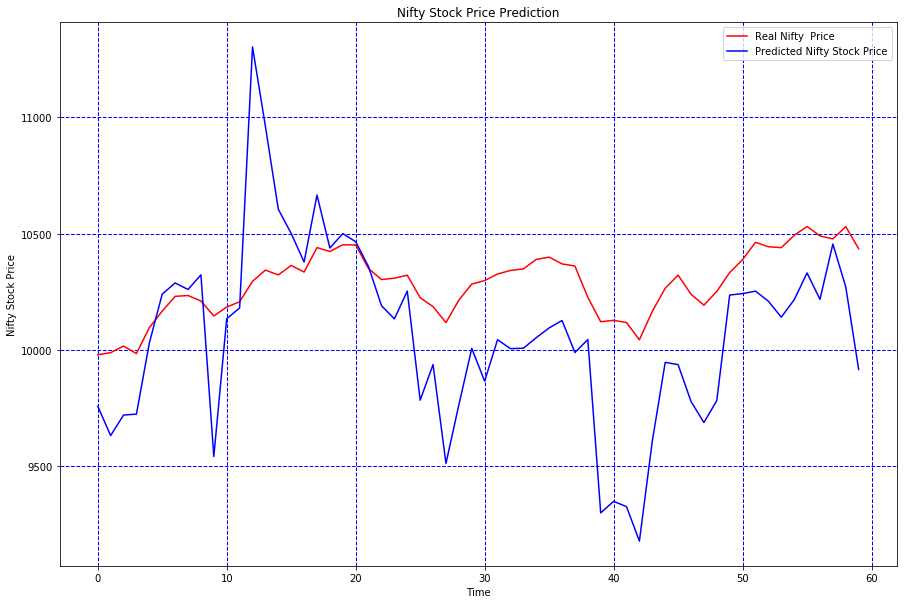

80
Epoch 1/20
946/946 [==============================] - 9s 9ms/step - loss: 0.1979
Epoch 2/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0540
Epoch 3/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0401
Epoch 4/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0346
Epoch 5/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0331
Epoch 6/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0280
Epoch 7/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0253
Epoch 8/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0231
Epoch 9/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0204
Epoch 10/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0164
Epoch 11/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0125
Epoch 12/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 13/20
946/946 [=

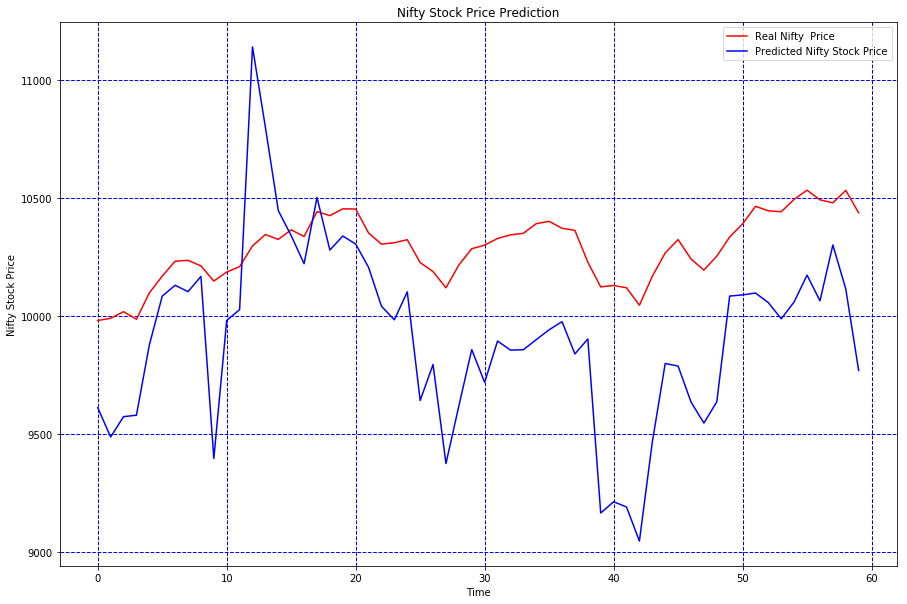

80
Epoch 1/20
946/946 [==============================] - 9s 10ms/step - loss: 0.1982
Epoch 2/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0538
Epoch 3/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0400
Epoch 4/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0343
Epoch 5/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0316
Epoch 6/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0268
Epoch 7/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 8/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0216
Epoch 9/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0188
Epoch 10/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0157
Epoch 11/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0125
Epoch 12/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0099
Epoch 13/20
946/946 [

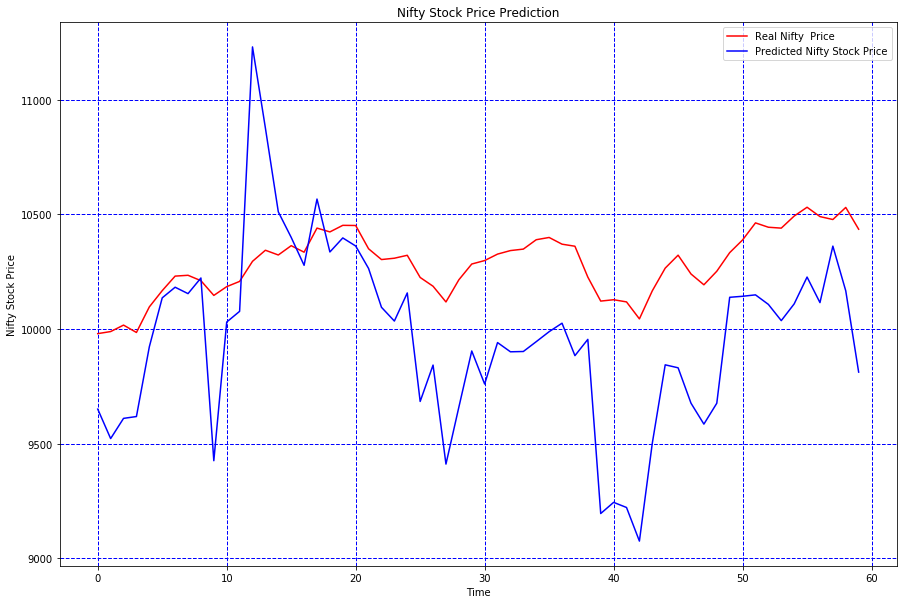

80
Epoch 1/20
946/946 [==============================] - 10s 10ms/step - loss: 0.1958
Epoch 2/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0514
Epoch 3/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0376
Epoch 4/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0317
Epoch 5/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0294
Epoch 6/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0240
Epoch 7/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0221
Epoch 8/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0202
Epoch 9/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0171
Epoch 10/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0145
Epoch 11/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0115
Epoch 12/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0101
Epoch 13/20
946/946 

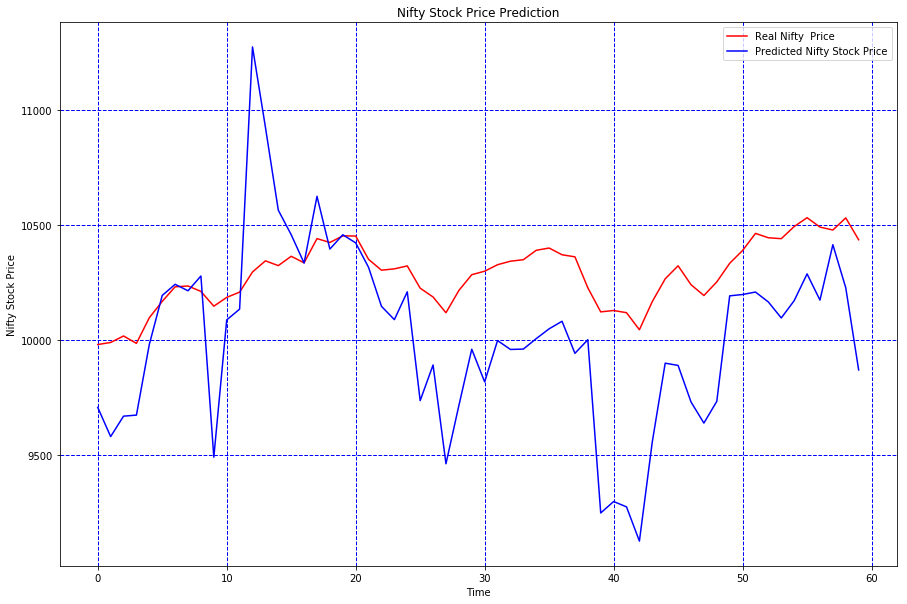

80
Epoch 1/20
946/946 [==============================] - 10s 11ms/step - loss: 0.1934
Epoch 2/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0513
Epoch 3/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0388
Epoch 4/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0298
Epoch 5/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0313
Epoch 6/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0262
Epoch 7/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0233
Epoch 8/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0209
Epoch 9/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0180
Epoch 10/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0148
Epoch 11/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0121
Epoch 12/20
946/946 [==============================] - 2s 2ms/step - loss: 0.0105
Epoch 13/20
946/946 

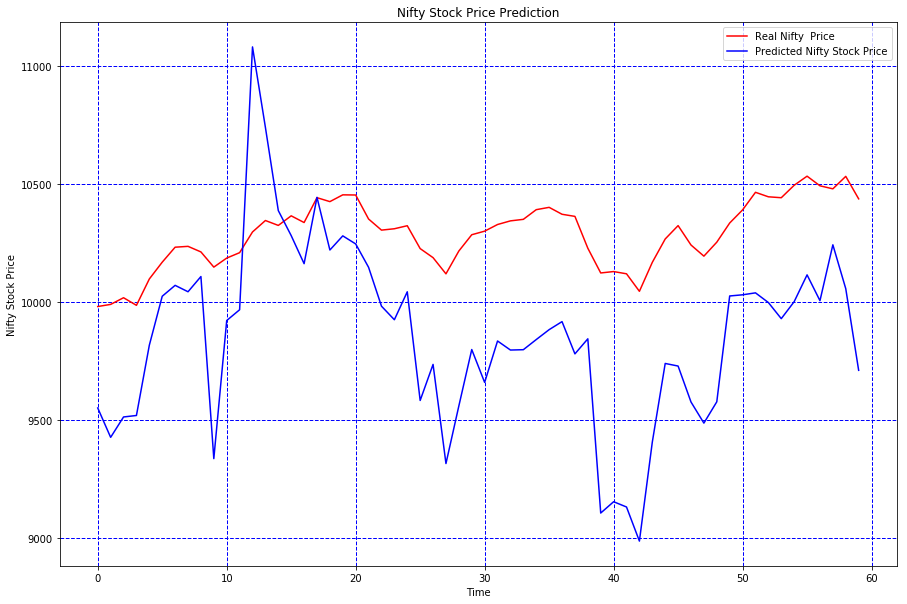

In [8]:
def start_run():
    b=ta()
    data=b.get_panel_data()
    skip_days=sorted([(sorted(v).pop()) for k,v in b.featuredict.items()]).pop()
    t=ml_dpmodels()
    d2 = dict((k,  t.predict_visualise(v,skip_days)) for k,v in data.items())



start_run()
